In [35]:
!pip install -q torchvision
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign, box_iou
from torchvision import transforms as T
from torchvision.models import vgg16


In [36]:
# Custom Dataset for Signature Detection
class SignatureDetectionDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_list = sorted(os.listdir(image_folder))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img_filename = self.image_list[index]
        img_path = os.path.join(self.image_folder, img_filename)
        label_path = os.path.join(self.label_folder, os.path.splitext(img_filename)[0] + '.txt')

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    coords = list(map(int, line.replace(',', ' ').split()))
                    if len(coords) == 4 and coords[2] > coords[0] and coords[3] > coords[1]:
                        boxes.append(coords)

        if not boxes:
            return None  # Ignore samples with no valid annotations

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes_tensor),), dtype=torch.int64)

        return image, {'boxes': boxes_tensor, 'labels': labels}

In [37]:
def create_vgg_frcnn(num_classes):
    vgg = vgg16(weights=None).features
    # VGG16 ends with a maxpool, which outputs feature maps with 512 channels
    vgg.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],  # Only one feature map from VGG
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=vgg,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model


In [38]:
# Paths and transforms
transform = T.ToTensor()

train_data = SignatureDetectionDataset(
    image_folder="/kaggle/input/faster-rcnn/OD Data/OD Data/TrainImages/",
    label_folder="/kaggle/input/faster-rcnn/OD Data/OD Data/TrainGroundTruth",
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*[d for d in x if d])))

val_data = SignatureDetectionDataset(
    image_folder="/kaggle/input/faster-rcnn/OD Data/OD Data/TestImages",
    label_folder="/kaggle/input/faster-rcnn/OD Data/OD Data/TestGroundTruth",
    transform=transform
)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*[d for d in x if d])))


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_vgg_frcnn(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [40]:
# Training with early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 3
epochs = 10

for epoch in range(epochs):
    model.train()
    cumulative_loss = 0.0
    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()

    mean_loss = cumulative_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {mean_loss:.4f}")

    if mean_loss < best_loss:
        best_loss = mean_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_mobilenet_frcnn.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping due to no improvement.")
            break

100%|██████████| 660/660 [03:20<00:00,  3.28it/s]


Epoch 1, Loss: 0.1026


100%|██████████| 660/660 [03:19<00:00,  3.31it/s]


Epoch 2, Loss: 0.0687


100%|██████████| 660/660 [03:19<00:00,  3.31it/s]


Epoch 3, Loss: 0.0571


100%|██████████| 660/660 [03:19<00:00,  3.32it/s]


Epoch 4, Loss: 0.0554


100%|██████████| 660/660 [03:19<00:00,  3.31it/s]


Epoch 5, Loss: 0.0522


100%|██████████| 660/660 [03:19<00:00,  3.31it/s]


Epoch 6, Loss: 0.0541


100%|██████████| 660/660 [03:18<00:00,  3.32it/s]


Epoch 7, Loss: 0.0550


100%|██████████| 660/660 [03:18<00:00,  3.33it/s]


Epoch 8, Loss: 0.0479


100%|██████████| 660/660 [03:17<00:00,  3.33it/s]


Epoch 9, Loss: 0.0468


100%|██████████| 660/660 [03:18<00:00,  3.33it/s]


Epoch 10, Loss: 0.0468


In [41]:
# Evaluation using IoU accuracy
def iou_score(pred_boxes, gt_boxes, threshold=0.5):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0

    ious = box_iou(pred_boxes, gt_boxes)
    matched = set()
    correct = 0

    for i in range(len(pred_boxes)):
        row = ious[i]
        max_iou, max_j = row.max(0)
        if max_iou > threshold and max_j.item() not in matched:
            matched.add(max_j.item())
            correct += 1

    return correct / len(gt_boxes)

In [42]:
def validate_model(model, loader, threshold=0.5):
    model.eval()
    total_score, count = 0, 0

    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = [img.to(device) for img in images]
            results = model(images)

            for pred, tgt in zip(results, targets):
                score = iou_score(pred["boxes"].cpu(), tgt["boxes"].cpu(), threshold)
                total_score += score
                count += 1

    avg_score = total_score / count if count else 0
    print(f"IoU Accuracy (threshold={threshold}): {avg_score:.4f}")
    return avg_score

# Run evaluation
validate_model(model, val_loader)

100%|██████████| 115/115 [00:14<00:00,  8.16it/s]

IoU Accuracy (threshold=0.5): 0.9739


0.973913043478261

In [43]:
# Visual test
def visualize_predictions(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(img_tensor)[0]

    img_np = np.array(image)
    for box in result['boxes'].cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img_np)
    plt.title("Detected Signatures")
    plt.axis('off')
    plt.show()

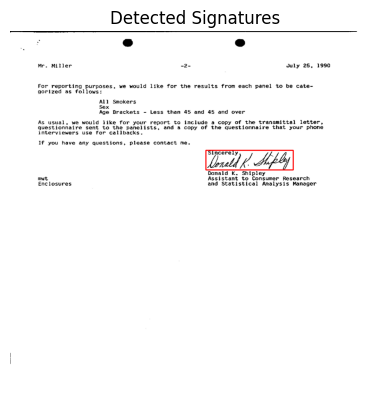

In [44]:
# Visualize example
visualize_predictions(model, "/kaggle/input/faster-rcnn/OD Data/OD Data/TestImages/799.tif")